In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('oil_and_gas.csv', index_col=['date'])
prices.head(10)

RELIANCE.NS     ONGC.NS     BPCL.NS      IOC.NS     GAIL.NS  \
date                                                                      
01-01-2018   901.207459  192.350006  508.600006  194.975006  186.993790   
02-01-2018   902.594299  196.850006  499.799988  193.199997  185.381302   
03-01-2018   906.210022  193.449997  494.899994  193.149994  183.787552   
04-01-2018   911.658386  199.500000  491.500000  193.649994  186.262543   
05-01-2018   914.580688  198.449997  487.700012  191.925003  185.400040   
08-01-2018   919.830933  197.399994  497.200012  194.274994  186.525040   
09-01-2018   932.114502  197.000000  496.100006  196.199997  187.856293   
10-01-2018   933.501343  197.899994  494.299988  194.774994  186.037552   
11-01-2018   928.944519  197.899994  492.399994  194.449997  185.812546   
12-01-2018   940.088867  200.750000  489.899994  194.524994  187.931290   

            HINDPETRO.NS      IGL.NS  PETRONET.NS  GUJGASLTD.NS  
date                                                             
01-01-2018    413.750000  339.750000   255.899994    168.830002  
02-01-2018    406.399994  335.200012   252.750000    169.399994  
03-01-2018    410.950012  332.750000   253.600006    174.639999  
04-01-2018    418.850006  329.049988   252.699997    169.910004  
05-01-2018    415.000000  329.850006   252.149994    174.179993  
08-01-2018    421.149994  328.200012   254.699997    177.100006  
09-01-2018    417.250000  323.049988   253.199997    174.460007  
10-01-2018    424.549988  325.750000   251.000000    172.149994  
11-01-2018    420.950012  322.250000   249.449997    174.789993  
12-01-2018    425.899994  327.500000   252.500000    181.929993

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17212\4246285030.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_close.head(2).append(train_close.tail(2))


RELIANCE.NS     ONGC.NS     BPCL.NS      IOC.NS     GAIL.NS  \
date                                                                      
01-01-2018   901.207459  192.350006  508.600006  194.975006  186.993790   
02-01-2018   902.594299  196.850006  499.799988  193.199997  185.381302   
30-12-2020  1995.500000   93.250000  382.850006   90.900002  123.099998   
31-12-2020  1985.300049   93.050003  381.100006   90.949997  123.250000   

            HINDPETRO.NS      IGL.NS  PETRONET.NS  GUJGASLTD.NS  
date                                                             
01-01-2018    413.750000  339.750000   255.899994    168.830002  
02-01-2018    406.399994  335.200012   252.750000    169.399994  
30-12-2020    216.449997  505.549988   246.500000    382.200012  
31-12-2020    217.899994  502.350006   247.600006    376.399994

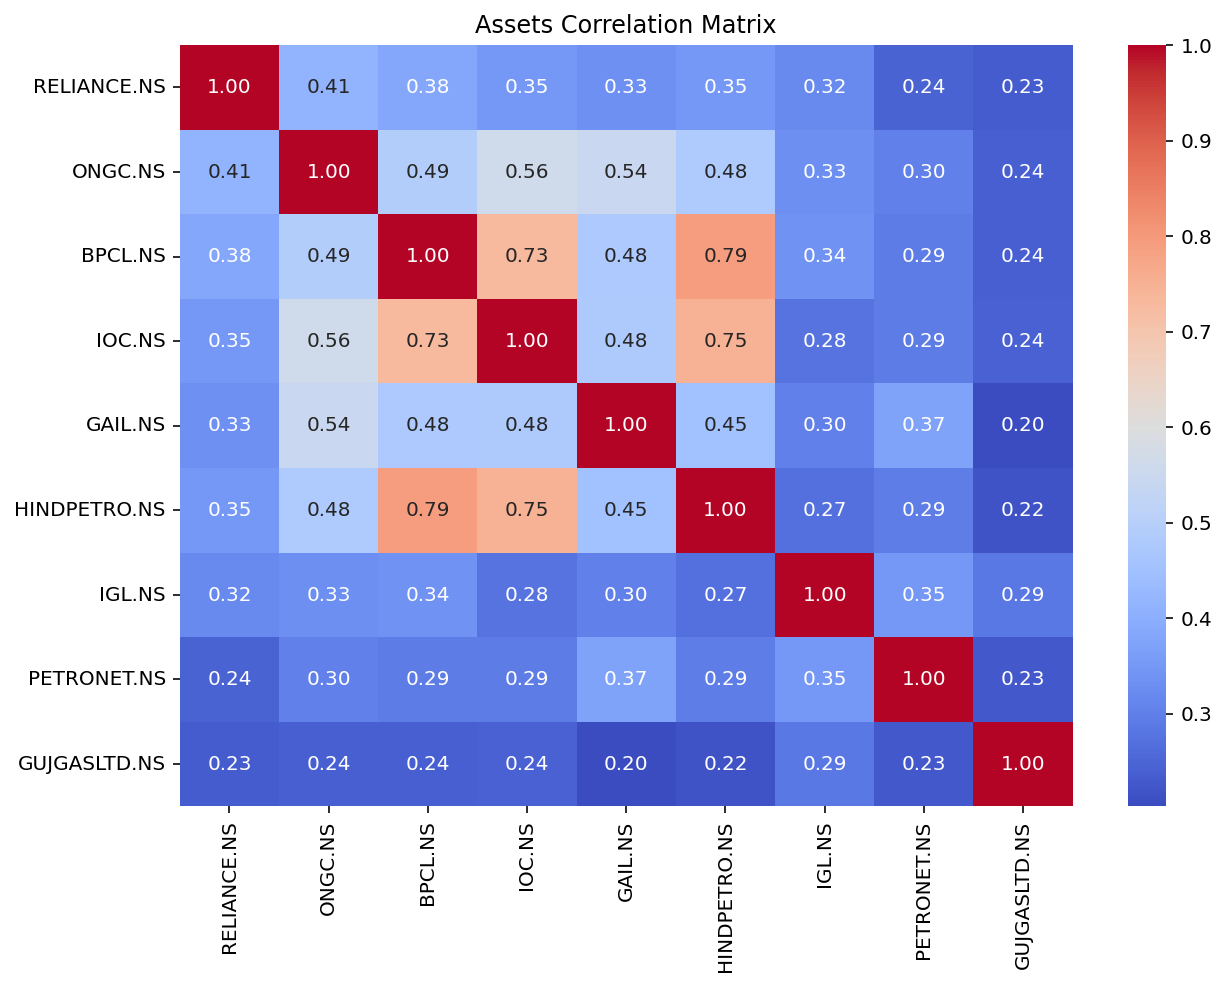

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('ONGC.NS', 'IOC.NS'), ('BPCL.NS', 'PETRONET.NS'), ('HINDPETRO.NS', 'IGL.NS')]


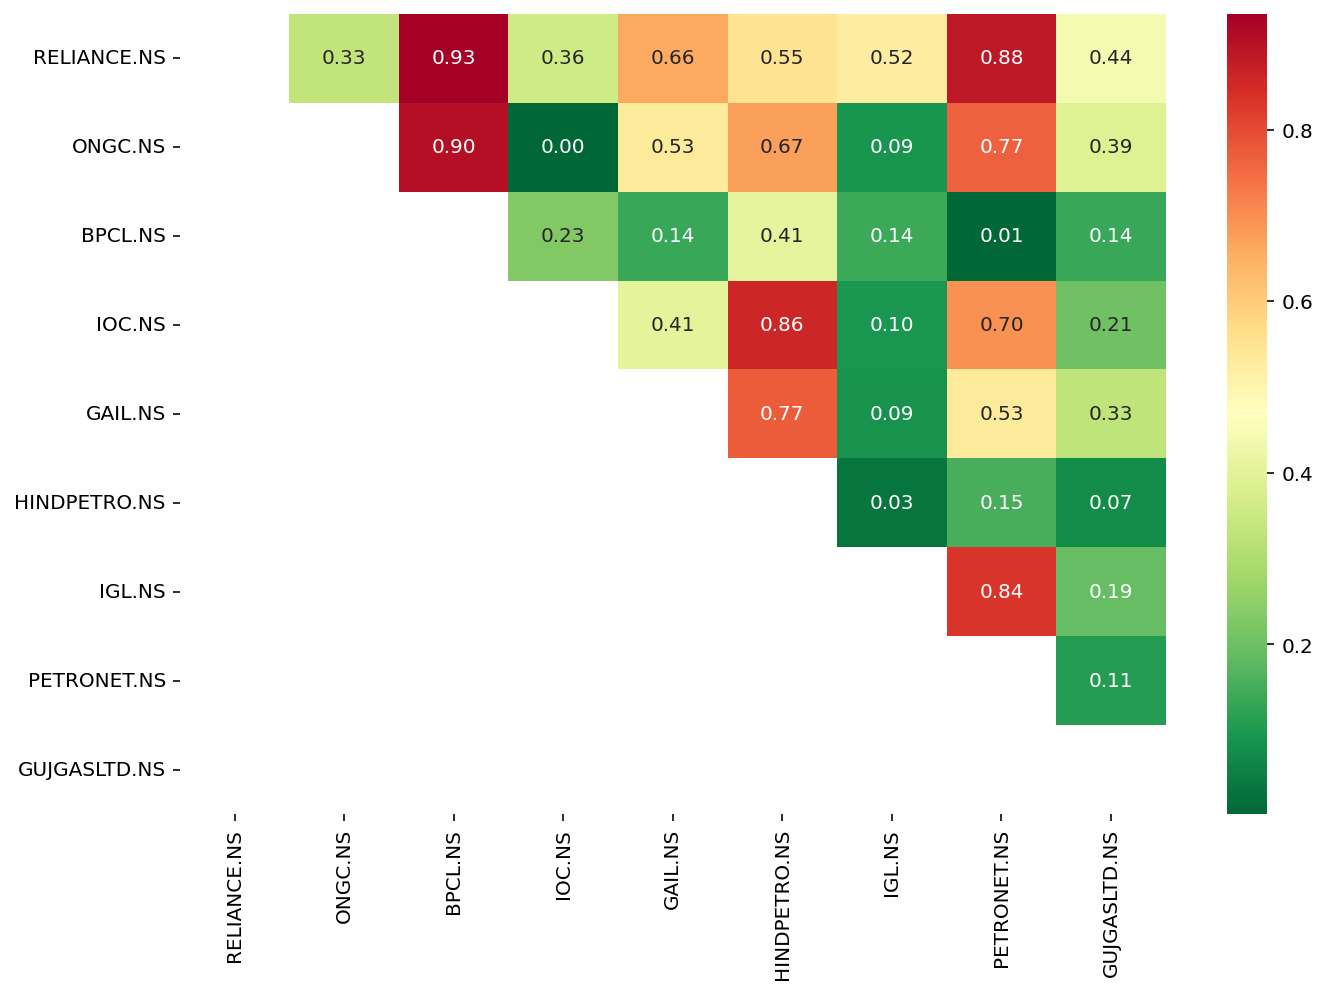

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
#ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'GAIL.NS'
asset2 = 'IGL.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

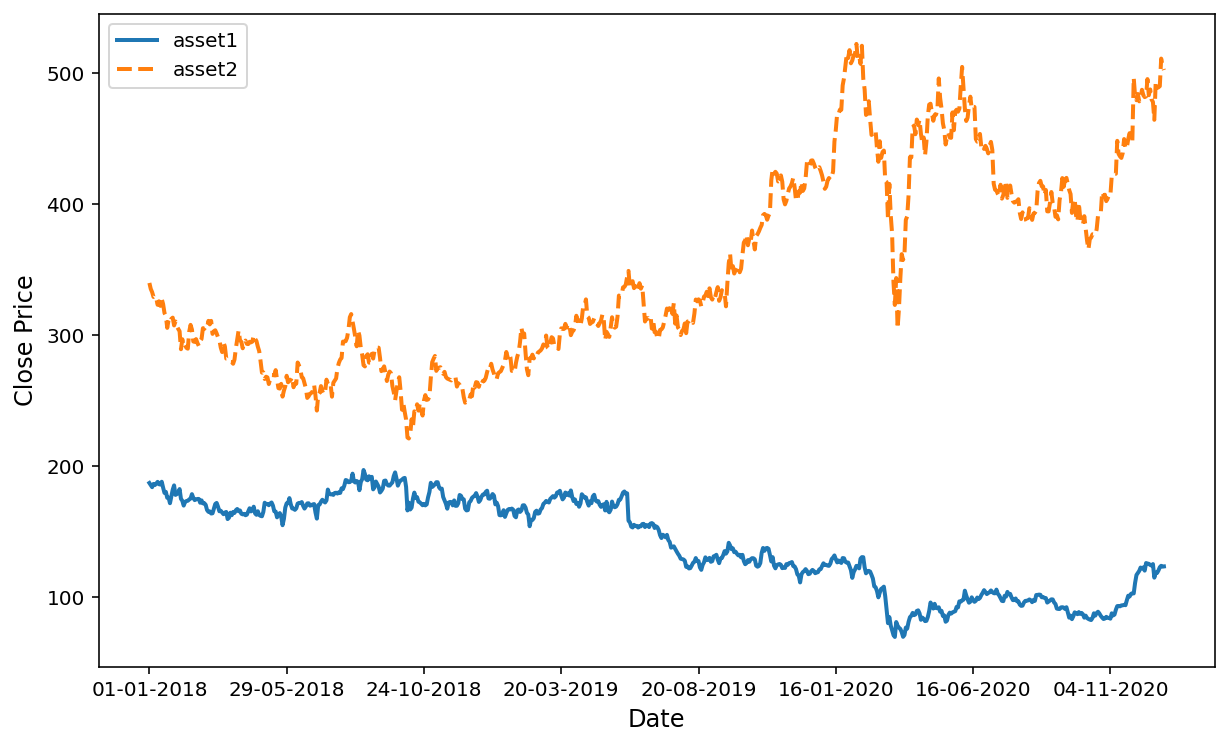

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1']].plot(figsize=(10, 6), linewidth=2,linestyle='solid', label = "asset1")
plt.plot(train[['asset2']], linewidth=2, linestyle='dashed', label = "asset2")
ax.set_ylabel("Close Price", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
plt.legend()
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
#ax.grid(True);
plt.savefig('chart3', dpi=500) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.822
Model:                            OLS   Adj. R-squared (uncentered):              0.822
Method:                 Least Squares   F-statistic:                              3409.
Date:                Sun, 10 Jul 2022   Prob (F-statistic):                   4.81e-279
Time:                        11:05:30   Log-Likelihood:                         -4761.6
No. Observations:                 740   AIC:                                      9525.
Df Residuals:                     739   BIC:                                      9530.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         2.2270      0.038     58.387      0.000       2.152       2.302
==============================================================================
Omnibus:                     4421.388   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.007
Skew:                           0.249   Prob(JB):                     2.11e-19
Kurtosis:                       1.406   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

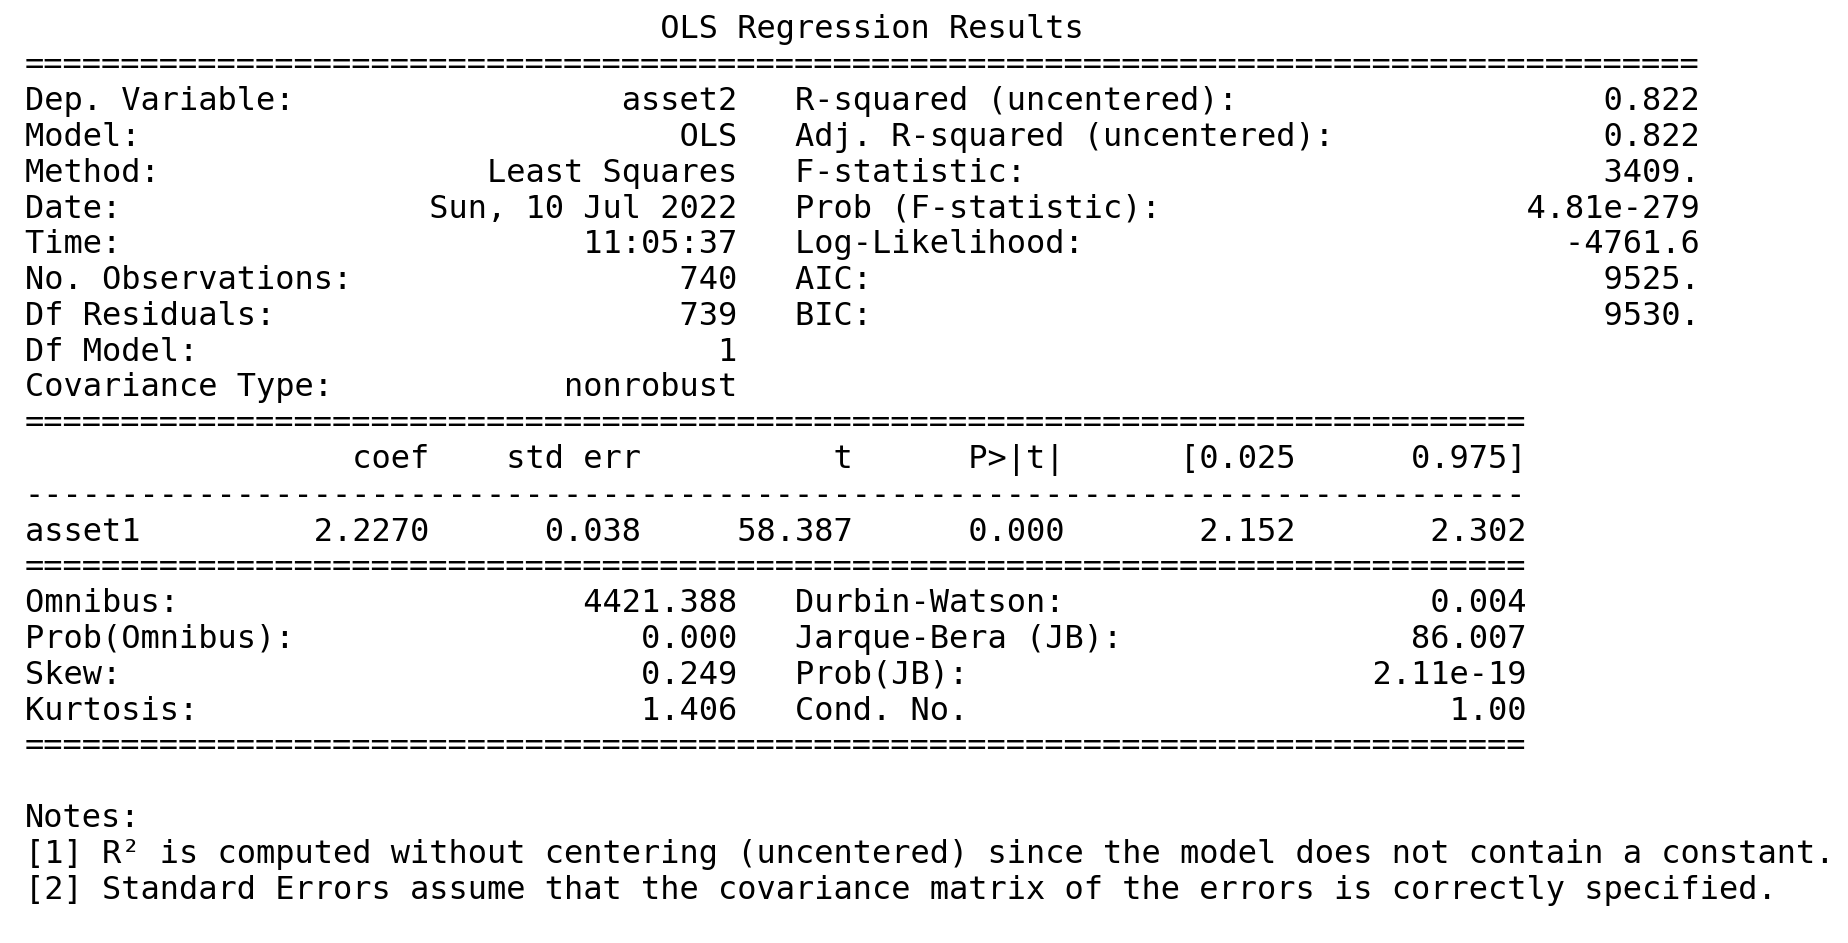

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  2.227003854979598


In [15]:
# calculate spread
residual = train.asset2 - model.params[0] * train.asset1

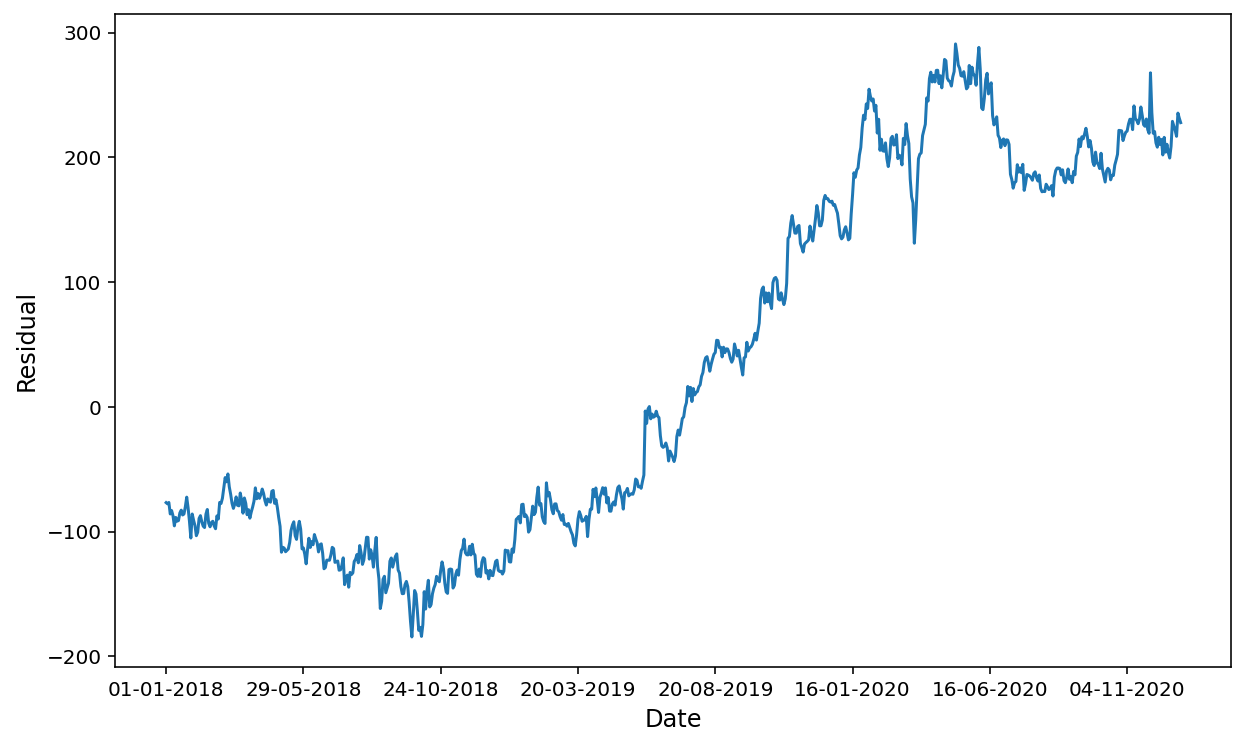

In [16]:
# Plot the residual
ax = residual.plot(figsize=(10, 6))
ax.set_ylabel("Residual", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
# ax.grid(True);
plt.savefig('chart5', dpi=500);

In [21]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(residual, maxlag = 1)
adf

(-0.4969328679021102,
 0.8926136384216252,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 5353.630599430096)

In [22]:
print('Critical Value = ', adf[0])

Critical Value =  -0.4969328679021102


In [23]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [24]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [25]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [26]:
signals.head()

asset1      asset2
date                              
01-01-2021  123.650002  507.149994
04-01-2021  128.000000  506.700012
05-01-2021  129.300003  519.049988
06-01-2021  134.000000  542.400024
07-01-2021  133.449997  540.000000

In [27]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [28]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                      
01-01-2021  123.650002  507.149994 -1.493500            1.0           -1.0
04-01-2021  128.000000  506.700012 -1.090419            1.0           -1.0
05-01-2021  129.300003  519.049988 -1.250983            1.0           -1.0
06-01-2021  134.000000  542.400024 -1.345271            1.0           -1.0
07-01-2021  133.449997  540.000000 -1.341630            1.0           -1.0

In [29]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [30]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

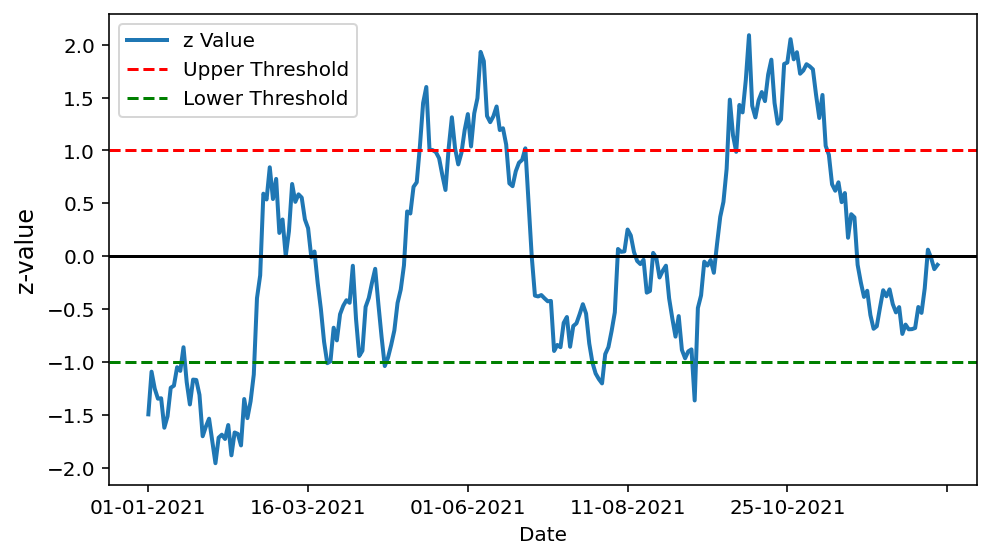

In [32]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value", figsize=(7, 4), linewidth=2)
#plt.title("Z-score Evaluation")
plt.ylabel("z-value", fontsize=12)
plt.xlabel("Date")
plt.axhline(signals['z'].mean(),linestyle= 'solid', color="black")
plt.axhline(signals['z upper limit'].mean(), linestyle= 'dashed',color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), linestyle = 'dashed', color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=500);

In [33]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  123.650002  507.149994 -1.493500            1.0           -1.0   
04-01-2021  128.000000  506.700012 -1.090419            1.0           -1.0   
05-01-2021  129.300003  519.049988 -1.250983            1.0           -1.0   
29-12-2021  132.250000  479.000000 -0.015056            1.0           -1.0   
30-12-2021  127.650002  466.250000 -0.121116            1.0           -1.0   
31-12-2021  129.199997  470.399994 -0.080829            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [34]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  123.650002  507.149994 -1.493500            1.0           -1.0   
04-01-2021  128.000000  506.700012 -1.090419            1.0           -1.0   
05-01-2021  129.300003  519.049988 -1.250983            1.0           -1.0   
06-01-2021  134.000000  542.400024 -1.345271            1.0           -1.0   
07-01-2021  133.449997  540.000000 -1.341630            1.0           -1.0   
08-01-2021  132.750000  550.700012 -1.619746            1.0           -1.0   
11-01-2021  135.699997  557.500000 -1.512066            1.0           -1.0   
12-01-2021  141.399994  567.200012 -1.242473            1.0           -1.0   
13-01-2021  141.250000  565.599976 -1.222321            1.0           -1.0   
14-01-2021  144.000000  567.950012 -1.047897            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
08-01-2021         1         0.0        -1         0.0  
11-01-2021         1         0.0        -1         0.0  
12-01-2021         1         0.0        -1         0.0  
13-01-2021         1         0.0        -1         0.0  
14-01-2021         1         0.0        -1         0.0

In [35]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  123.650002  507.149994 -1.493500            1.0           -1.0   
18-01-2021  137.899994  535.200012 -0.859340            1.0           -1.0   
19-01-2021  139.649994  557.549988 -1.188614            1.0           -1.0   
19-02-2021  145.399994  542.950012 -0.395160            1.0           -1.0   
24-03-2021  131.000000  515.000000 -1.010092            1.0           -1.0   
14-09-2021  156.000000  587.000000 -0.488503            1.0           -1.0   
28-09-2021  159.500000  516.599976  1.480375            1.0           -1.0   
30-09-2021  158.850006  533.099976  0.986895            1.0           -1.0   
01-10-2021  163.149994  530.299988  1.430297            1.0           -1.0   
12-11-2021  148.000000  497.700012  0.959130            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
18-01-2021         0        -1.0         0         1.0  
19-01-2021         1         1.0        -1        -1.0  
19-02-2021         0        -1.0         0         1.0  
24-03-2021         1         1.0        -1        -1.0  
14-09-2021         0        -1.0         0         1.0  
28-09-2021        -1        -1.0         1         1.0  
30-09-2021         0         1.0         0        -1.0  
01-10-2021        -1        -1.0         1         1.0  
12-11-2021         0         1.0         0        -1.0

In [36]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

152.800003    2
139.649994    1
131.000000    1
129.399994    1
155.050003    1
153.350006    1
139.050003    1
145.899994    1
158.850006    1
148.000000    1
Name: asset1, dtype: int64

In [37]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  123.650002  507.149994 -1.493500            1.0           -1.0   
04-01-2021  128.000000  506.700012 -1.090419            1.0           -1.0   
05-01-2021  129.300003  519.049988 -1.250983            1.0           -1.0   
06-01-2021  134.000000  542.400024 -1.345271            1.0           -1.0   
07-01-2021  133.449997  540.000000 -1.341630            1.0           -1.0   
...                ...         ...       ...            ...            ...   
27-12-2021  130.550003  483.899994 -0.303984            1.0           -1.0   
28-12-2021  133.050003  478.950012  0.062759            1.0           -1.0   
29-12-2021  132.250000  479.000000 -0.015056            1.0           -1.0   
30-12-2021  127.650002  466.250000 -0.121116            1.0           -1.0   
31-12-2021  129.199997  470.399994 -0.080829            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         1         0.0        -1         0.0  
05-01-2021         1         0.0        -1         0.0  
06-01-2021         1         0.0        -1         0.0  
07-01-2021         1         0.0        -1         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [38]:
signals = signals.reset_index()

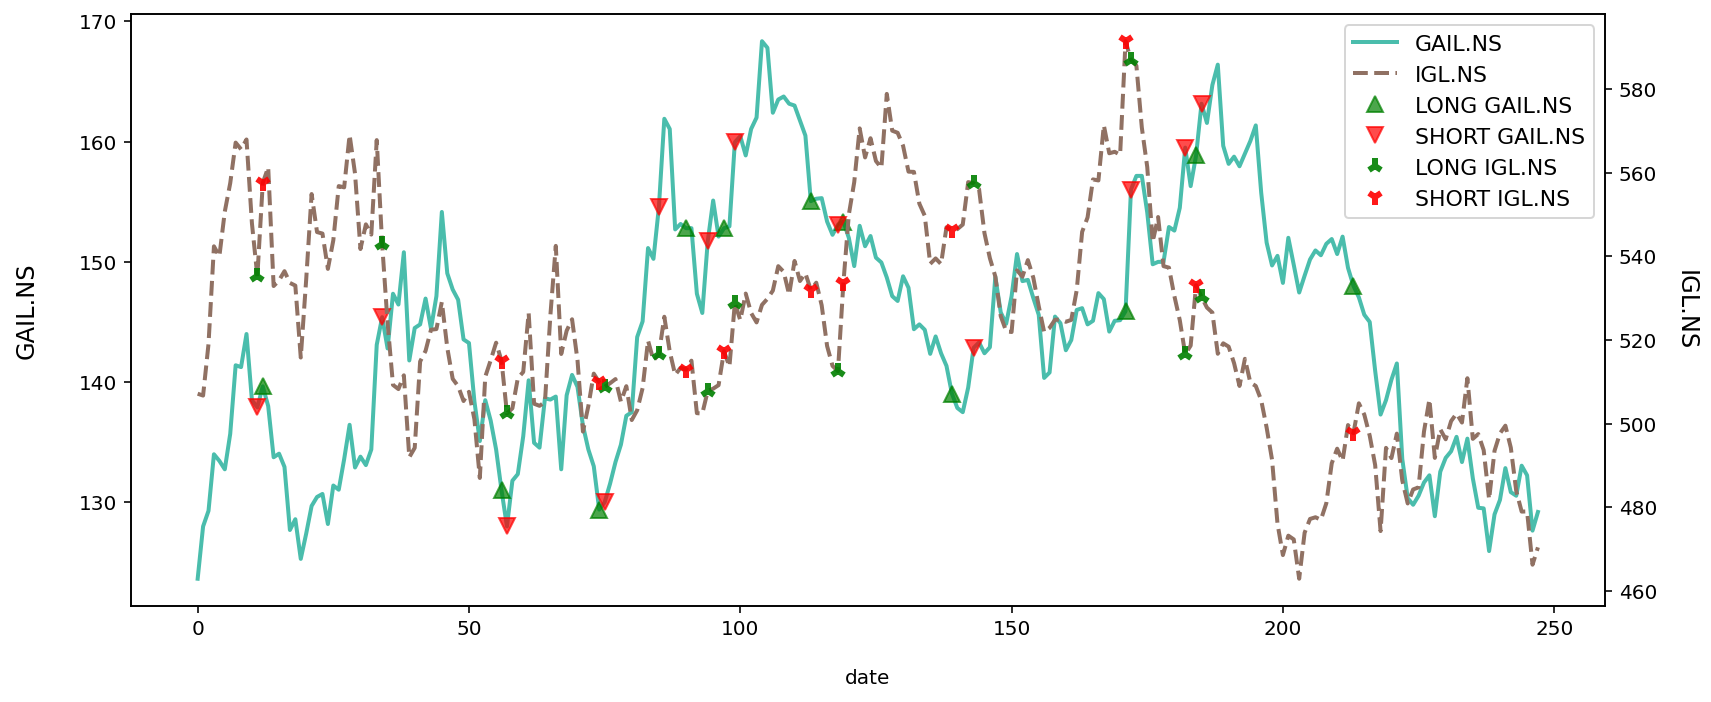

In [40]:
# visualize trading signals and position
fig=plt.figure(figsize=(12,5))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac', linestyle = 'solid', linewidth=2)
l2, = bx2.plot(signals['asset2'], c='#907163', linestyle = 'dashed', linewidth=2)

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, 
              marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,
              marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,
               marker='2',markersize=8, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,
               marker='1',markersize=8, c='r',alpha=0.9,markeredgewidth=3)
bx.set_ylabel(asset1,fontsize=12)
bx2.set_ylabel(asset2, rotation=270, fontsize=12)
bx.yaxis.labelpad=20
bx2.yaxis.labelpad=20
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best', fontsize = 11)

#plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date', fontsize=12)
#plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=500);

### Portfolio Profit and Loss Calculation

In [41]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [42]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [43]:
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    123.650002           NaN            NaN            NaN       NaN   
1    128.000000      0.000000  100000.000000  100000.000000       NaN   
2    129.300003      0.000000  100000.000000  100000.000000  0.000000   
3    134.000000      0.000000  100000.000000  100000.000000  0.000000   
4    133.449997      0.000000  100000.000000  100000.000000  0.000000   
243  130.550003 -77546.701841  204692.490793  127145.788952  0.001404   
244  133.050003 -79031.701841  204692.490793  125660.788952 -0.011680   
245  132.250000 -78556.500000  204692.490793  126135.990793  0.003782   
246  127.650002 -75824.100891  204692.490793  128868.389902  0.021662   
247  129.199997 -76744.798159  204692.490793  127947.692634 -0.007144   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [44]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   123.650002           NaN            NaN            NaN       NaN   
11  137.899994 -81912.596377  181912.596377  100000.000000  0.000000   
12  139.649994      0.000000   98960.500000   98960.500000 -0.010395   
34  145.399994 -86367.596377  185328.096377   98960.500000  0.000000   
56  131.000000      0.000000  107514.096377  107514.096377  0.019144   

    positions1  
0          NaN  
11        -1.0  
12         1.0  
34        -1.0  
56         1.0

In [45]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [46]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1          cash1   total asset1   return1  \
0    123.650002           NaN            NaN            NaN       NaN   
1    128.000000      0.000000  100000.000000  100000.000000       NaN   
2    129.300003      0.000000  100000.000000  100000.000000  0.000000   
3    134.000000      0.000000  100000.000000  100000.000000  0.000000   
4    133.449997      0.000000  100000.000000  100000.000000  0.000000   
243  130.550003 -77546.701841  204692.490793  127145.788952  0.001404   
244  133.050003 -79031.701841  204692.490793  125660.788952 -0.011680   
245  132.250000 -78556.500000  204692.490793  126135.990793  0.003782   
246  127.650002 -75824.100891  204692.490793  128868.389902  0.021662   
247  129.199997 -76744.798159  204692.490793  127947.692634 -0.007144   

     positions1      asset2     holdings2          cash2   total asset2  \
0           NaN  507.149994           NaN            NaN            NaN   
1           0.0  506.700012      0.000000  100000.000000  100000.000000   
2           0.0  519.049988      0.000000  100000.000000  100000.000000   
3           0.0  542.400024      0.000000  100000.000000  100000.000000   
4           0.0  540.000000      0.000000  100000.000000  100000.000000   
243         0.0  483.899994  81779.098969   15533.817525   97312.916494   
244         0.0  478.950012  80942.552062   15533.817525   96476.369587   
245         0.0  479.000000  80951.000000   15533.817525   96484.817525   
246         0.0  466.250000  78796.250000   15533.817525   94330.067525   
247         0.0  470.399994  79497.598969   15533.817525   95031.416494   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243 -0.017657         0.0  
244 -0.008596         0.0  
245  0.000088         0.0  
246 -0.022333         0.0  
247  0.007435         0.0

In [47]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   123.650002           NaN            NaN            NaN       NaN   
11  137.899994 -81912.596377  181912.596377  100000.000000  0.000000   
12  139.649994      0.000000   98960.500000   98960.500000 -0.010395   
34  145.399994 -86367.596377  185328.096377   98960.500000  0.000000   
56  131.000000      0.000000  107514.096377  107514.096377  0.019144   

    positions1      asset2     holdings2          cash2   total asset2  \
0          NaN  507.149994           NaN            NaN            NaN   
11        -1.0  535.200012  90448.802062    9551.197938  100000.000000   
12         1.0  557.549988      0.000000  103777.145876  103777.145876   
34        -1.0  542.950012  91758.552062   12018.593815  103777.145876   
56         1.0  515.000000      0.000000   99053.593815   99053.593815   

     return2  positions2  
0        NaN         NaN  
11  0.000000         1.0  
12  0.037771        -1.0  
34  0.000000         1.0  
56 -0.007367        -1.0

In [48]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

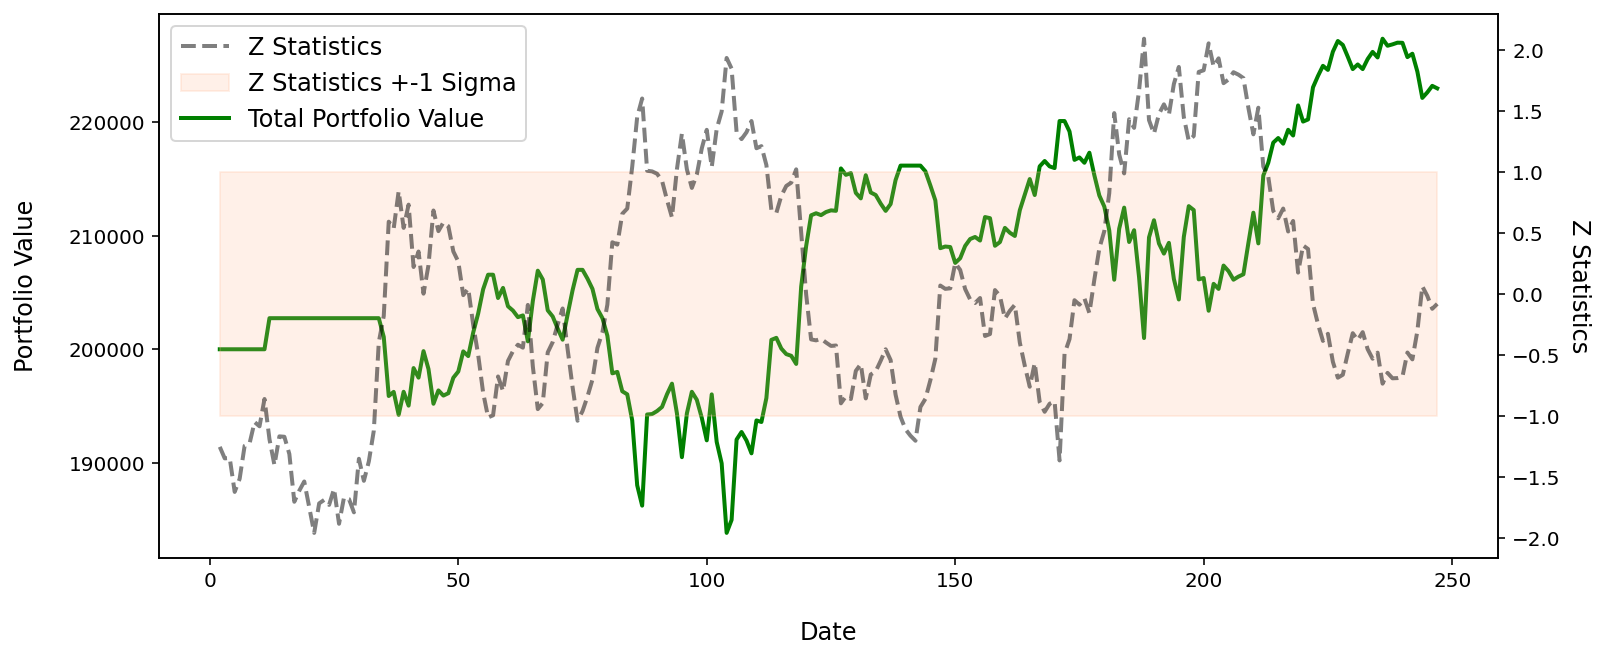

In [50]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(12,5),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g', linewidth = 2, linestyle='solid')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.5, linewidth = 2, 
               linestyle='dashed')

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value', fontsize=12)
ax2.set_ylabel('Z Statistics',rotation=270, fontsize=12)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date', fontsize=12)
ax.xaxis.labelpad=15
#plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left', fontsize=12);
plt.savefig('chart8', dpi=500);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [45]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

222979.10912880005

In [46]:
profit = final_portfolio - 2*initial_capital
profit

22979.109128800046

In [47]:
roi = (profit/(2*initial_capital))*100
roi

11.489554564400024

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 230.250%
